### Bar plot of Figure of Merit for WFD

- [time gaps](#time-gaps)
- [depth](#depth)
- [footprint](#footprint)
- [proper motion](#proper-motion)
- [all](#all)

In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline


In [135]:
plt.style.use('seaborn')
plt.rc('legend', fontsize=20) # using a size in points
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
plt.rcParams['axes.facecolor'] = "w"




In [57]:
filters = ['u', 'g', 'r', 'i', 'z', 'y']
cols_all = ['uu', 'ug', 'ur', 'ui', 'uz', 'uy', 'gg', 'gr', 'gi', 'gz', 'gy', 'rr', 'ri', 'rz', 'ry', 'ii', 'iz', 'iy', 'zz', 'zy', 'yy']

cols_same = [ 'uu',  'gg',  'rr',  'ii',  'zz',  'yy']

cols_diff = ['ug', 'ur', 'ui', 'uz', 'uy', 'gr', 'gi', 'gz', 'gy', 'ri', 'rz', 'ry', 'iz', 'iy', 'zy']


In [58]:
def scale(arr, mode=0):
    """scale array by max"""
    newarr = arr / arr.max()
    if mode==1:
        # scale to 0-1
        newarr = (arr - arr.min()) / (arr.max()-arr.min())
    return newarr

def get_family(df):
    """get family of opsim"""
    
    return df['db'].split('_')[0]


In [59]:
# get the name of all opsim dbs 
import os
import glob

workpath = os.getcwd()
dbpath = "/home/idies/workspace/lsst_cadence/FBS_1.5/"  # path to all opsim databases
os.chdir(dbpath)  # change to opsim database directory
dblist_all = glob.glob('*.db') 
#workpath = '/home/idies/workspace/Storage/lixl/persistent/LSST_OpSim/unknowns/timeGaps'
os.chdir(workpath) # change back to work directory
dblist_all.sort()


In [6]:
#dblist_all

In [144]:
def plot_barh(df_new, colon, byfamily=True, savefig=None, figsize=(8, 30), facecolor="#f1f1f3", **kwargs):
    """barh plot of FoM"""

    df_ = df_new.copy()
    df_['total'] = np.sum(df_[ colon ], axis=1)
    
    # get the max FOM of each family and sort by this
    df_mean_family = df_.groupby(by = "family", as_index=False).max()[['family', 'total']]
    df_ = df_.merge(df_mean_family, on='family', how='left', suffixes=['', '_fmean'],)
    
    df_ = df_.set_index('db')
    if byfamily:
        df_ = df_.sort_values(by=['total_fmean', 'total'], ascending=[True, True])
    else:
        # sort by total only
        df_ = df_.sort_values(by='total', ascending=True)
    
    df_[colon] = df_[colon]/len(colon)
    ax = df_[ colon ].plot.barh(stacked=True, figsize=figsize, **kwargs)
    
    # get positions of hlines
    if byfamily:
        hlines = df_.groupby(by='family', as_index=False, sort=False).count().cumsum()['total_fmean'].values - 0.5
        hlines = [hlines, hlines]
        ax.plot((-0.5, 1), hlines, 'k-', linewidth=1, alpha=0.5)
    
    plt.xlabel('normalized score', fontsize=20)
    plt.ylabel('')
    plt.legend(loc='lower right', frameon=True)
    plt.xlim([0,1.01])
    
    #ax = plt.gca()
    ax.set_facecolor(facecolor)
    
    if savefig!=None:
        plt.savefig(savefig, bbox_inches='tight')


def get_mycmap(pairs='diff'):
    """discrete colormap for filter pairs"""
    import numpy as np
    import matplotlib.colors as mcolors
    
    # colors in total
    # combine them and build a new colormap

    thecbases = [plt.cm.Blues,
                 plt.cm.Greens,
                 plt.cm.Purples,
                 plt.cm.Reds,
                 plt.cm.YlOrBr,
                 (240./255,230./255,140./255, 1.),
                ]

    grad = [thecbases[i](np.linspace(0, 1, 8-i)[::-1][1:]) for i in range(5)]
    
    #thecmaps = {'diff': , [thecbases[i](np.linspace(0, 1, 8-i)[::-1][1:]) for i in range(5)]
    #                'same':[thecbases[i](np.linspace(0, 1, 7-i)[-3 if i < 2 else -2]) 
    #                     for i in range(5)] + [thecbases[5]]}
    
    thecmaps = {'diff': [ grad[i] [ 1:6 - i ] for i in range(5) ] ,
                'same':[ grad[i] [ 1 if i!=5 else 0 ] for i in range(5) ] + [thecbases[5]]}
    
    colors = np.vstack( [c for c in thecmaps[pairs]] )
    mymap = mcolors.LinearSegmentedColormap.from_list('my_colormap', colors)
            
    #plt.pcolor(data, cmap=mymap)
    #plt.colorbar()
    #plt.show()
    return mymap


In [110]:
def h2rgba(h):
    rgba = list(int(h.lstrip('#')[i:i+2], 16) / 255 for i in (0, 2, 4) ) + [.7]
    return rgba

In [111]:
h2rgba('#BF2E5C')

[0.7490196078431373, 0.1803921568627451, 0.3607843137254902, 0.7]

### time gaps

In [131]:

fomcsv = './data/df_tgapsFoM_allsky_v1.5.csv' # for tgaps
df_fom = pd.read_csv(fomcsv)

if 'db' not in df_fom.columns:
    df_fom['db'] = dblist_all

In [132]:
# scale fom table to 0 and 1
df_new = df_fom[ ['db'] ].copy()
for col in cols_all:
    # df_new[ col ] = np.tanh ( scale ( df_fom[col] ) * 3 )
    df_new[col] = scale(df_fom[col]) 
    
df_new['db'] = df_new['db'].apply(lambda x: x.replace("_v1.5_10yrs.db", "") )
df_new['db'] = df_new['db'].apply(lambda x: x.replace("v1.5_10yrs.db", "") )

df_new['family'] = df_new.apply(get_family, axis=1)

df_new.head()

,db,uu,ug,ur,ui,uz,uy,gg,gr,gi,...,ri,rz,ry,ii,iz,iy,zz,zy,yy,family
0,agnddf,0.273559,0.293383,0.263814,0.134290,NaN,0.000644,0.138693,0.262300,0.171259,...,0.260899,0.115966,0.025167,0.024509,0.582016,0.143586,0.040970,0.443479,0.097494,agnddf
1,alt_dust,0.162127,0.683792,0.792606,0.683870,NaN,0.584975,0.240720,0.768939,0.814870,...,0.692041,0.776802,0.689698,0.039611,0.702228,0.827907,0.037562,0.727804,0.129181,alt
2,alt_roll_mod2_dust_sdf_0.20,0.162065,0.756340,0.816045,0.641002,NaN,0.139387,0.245412,0.814422,0.830206,...,0.775272,0.825048,0.671326,0.041664,0.742685,0.817874,0.039647,0.771715,0.105411,alt
3,baseline_2snaps,0.150138,0.534708,0.675779,0.635079,NaN,0.367526,0.209029,0.637264,0.683461,...,0.588755,0.670862,0.728454,0.035548,0.606810,0.759842,0.033855,0.591065,0.123783,baseline
4,baseline_samefilt,0.281328,0.321511,0.268324,0.390071,NaN,1.000000,0.278452,0.313892,0.266490,...,0.379226,0.584778,0.674871,0.050344,0.355515,0.516733,0.035310,0.311805,0.196775,baseline


In [133]:
filters

['u', 'g', 'r', 'i', 'z', 'y']

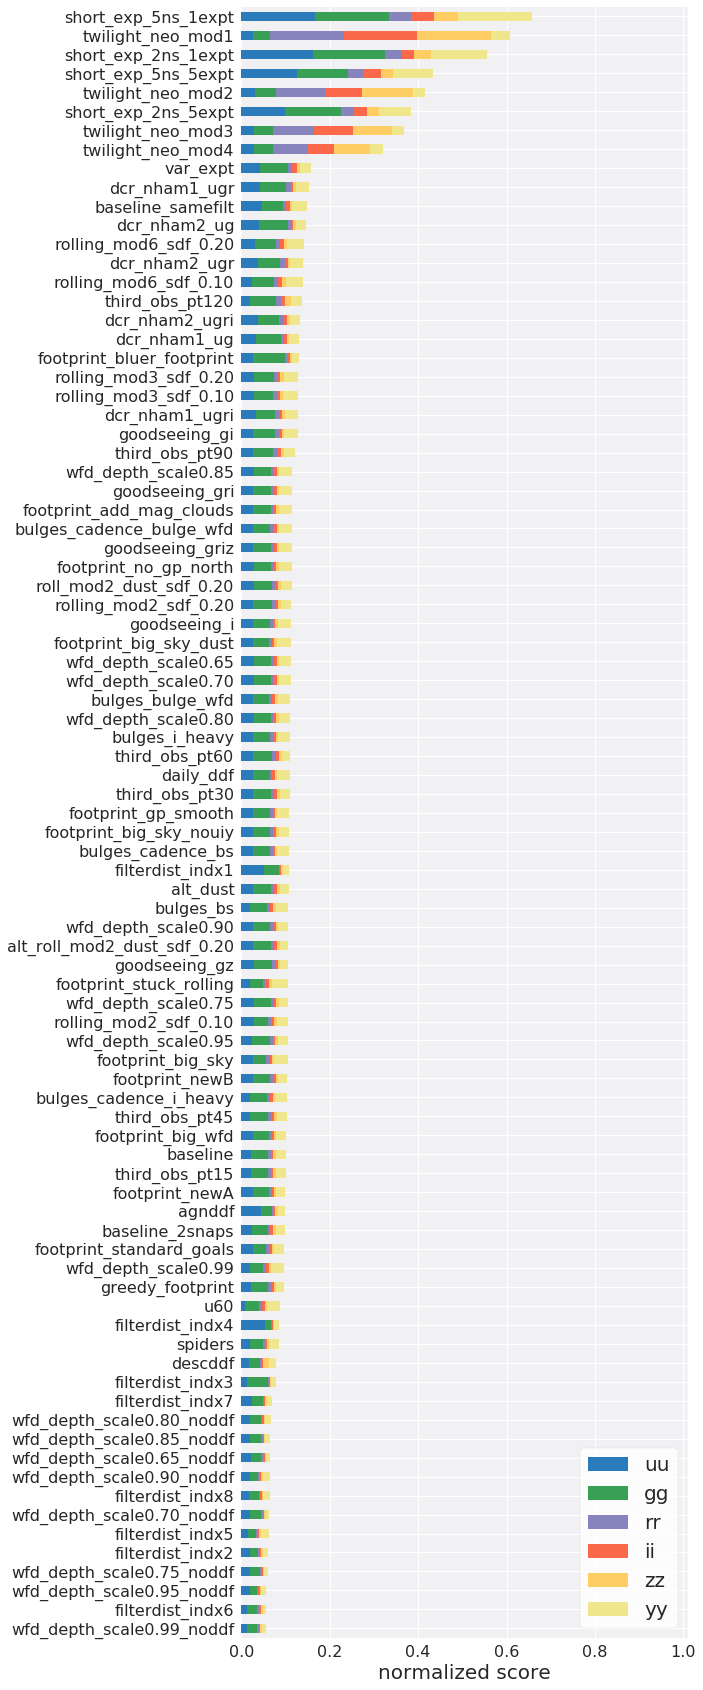

In [136]:
plot_barh(df_new, colon=cols_same, byfamily=False, savefig='figures/barh_tgaps_same.pdf', colormap=get_mycmap(pairs='same')) 
#ax = plt.gca()
#ax.set_facecolor("#f3f3f3")

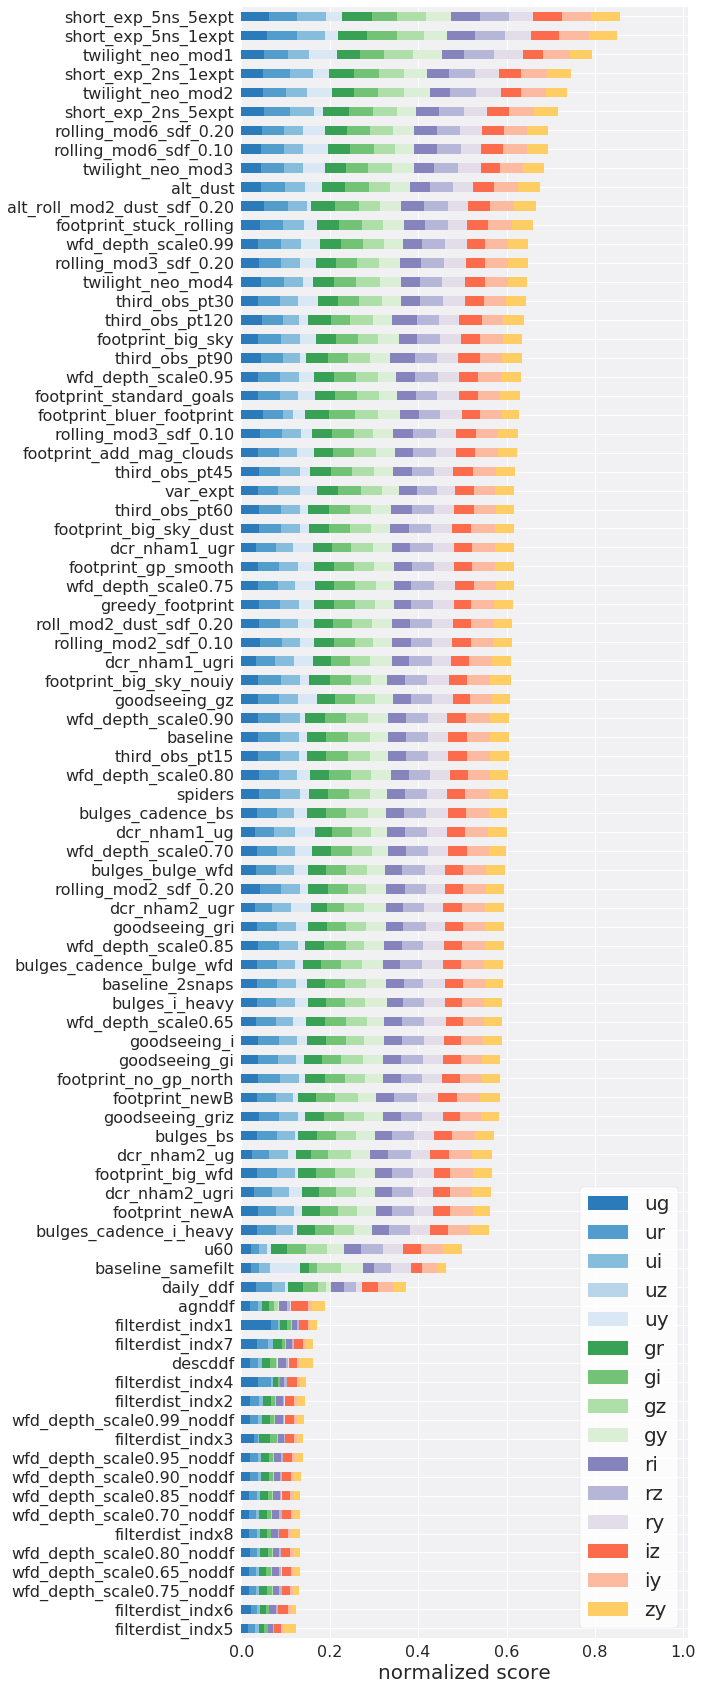

In [137]:
plot_barh(df_new, colon=cols_diff, byfamily=False, savefig='figures/barh_tgaps_diff.pdf', colormap=get_mycmap() )

#ax = plt.gca()
#ax.set_facecolor("#f3f3f3")


### depth

In [147]:
fomcsv = './data/depthFoM_v1.5.csv' # for tgaps
df_fom = pd.read_csv(fomcsv)

if 'db' not in df_fom.columns:
    df_fom['db'] = dblist_alla

In [148]:
df_fom.head()

,db,g,i,r,u,y,z
0,agnddf_v1.5_10yrs.db,-0.546022,-0.620969,-0.736184,-0.403453,-0.169655,-0.597247
1,alt_dust_v1.5_10yrs.db,-0.585299,-0.681369,-0.790087,-0.447163,-0.226876,-0.653423
2,alt_roll_mod2_dust_sdf_0.20_v1.5_10yrs.db,-0.605729,-0.747880,-0.846155,-0.452051,-0.269783,-0.700780
3,baseline_2snaps_v1.5_10yrs.db,-0.613958,-0.653665,-0.776170,-0.590098,-0.178243,-0.608488
4,baseline_samefilt_v1.5_10yrs.db,-0.589748,-0.618501,-0.791027,-0.389743,-0.185773,-0.654298


In [149]:
# scale fom table to 0 and 1
df_new = df_fom[ ['db'] ].copy()
for col in filters:
    # df_new[ col ] = np.tanh ( scale ( df_fom[col] ) * 3 )
    df_new[col] = scale(df_fom[col], mode=1) 
    
df_new['db'] = df_new['db'].apply(lambda x: x.replace("_v1.5_10yrs.db", "") )
df_new['db'] = df_new['db'].apply(lambda x: x.replace("v1.5_10yrs.db", "") )

df_new['family'] = df_new.apply(get_family, axis=1)

df_new.head()

,db,u,g,r,i,z,y,family
0,agnddf,0.791325,0.877899,0.947105,0.870985,0.915078,0.857861,agnddf
1,alt_dust,0.774883,0.820540,0.828575,0.771955,0.827502,0.494276,alt
2,alt_roll_mod2_dust_sdf_0.20,0.773044,0.790706,0.705284,0.662905,0.753673,0.221650,alt
3,baseline_2snaps,0.721116,0.778687,0.859178,0.817376,0.897554,0.803293,baseline
4,baseline_samefilt,0.796483,0.814043,0.826508,0.875032,0.826138,0.755444,baseline


In [150]:
df_new['db'].shape

(86,)

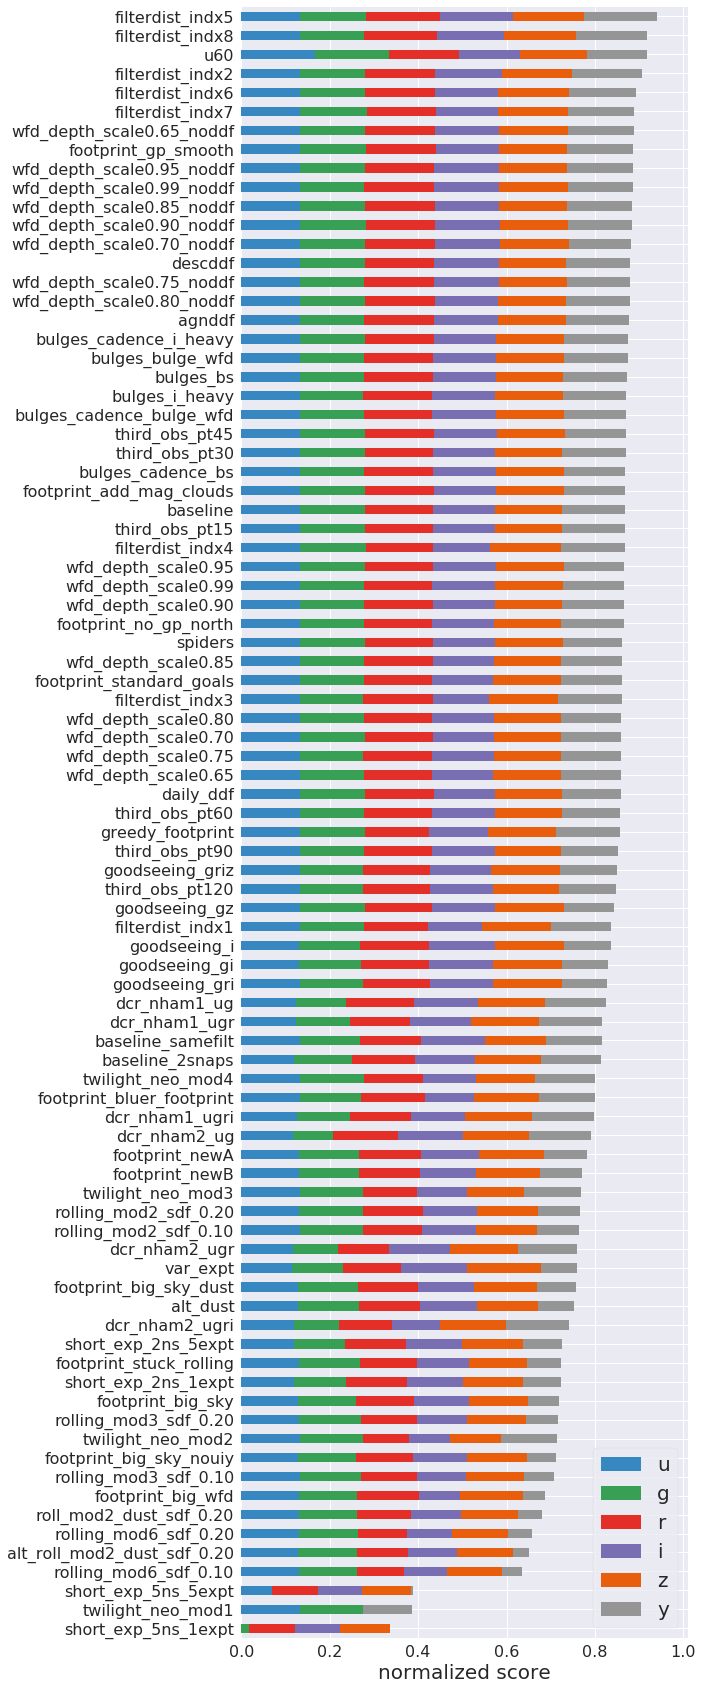

In [151]:
plot_barh(df_new, colon=filters, byfamily=False, savefig='figures/barh_depth.pdf', colormap=get_mycmap(pairs='same')) 



### footprint

footprint

In [138]:
fomcsv = './data/df_Nfields_allsky_v1.5.csv' # for tgaps
df_fom = pd.read_csv(fomcsv)

if 'db' not in df_fom.columns:
    df_fom['db'] = dblist_all

In [121]:
np.max( df_fom )

uu                                 1552
ug                                 1595
ur                                 1617
ui                                 1251
uz                                    0
uy                                  181
gg                                 1550
gr                                 1740
gi                                 1330
gz                                 1101
gy                                  514
rr                                 1447
ri                                 1603
rz                                 1358
ry                                 1287
ii                                 1452
iz                                 1705
iy                                 1314
zz                                 1477
zy                                 1491
yy                                 1452
db    wfd_depth_scale0.99_v1.5_10yrs.db
dtype: object

In [139]:
# scale fom table to 0 and 1
df_new = df_fom[ ['db'] ].copy()
for col in cols_all:
    # df_new[ col ] = np.tanh ( scale ( df_fom[col] ) * 3 )
    df_new[col] = scale(df_fom[col], mode=1) 
    
df_new['db'] = df_new['db'].apply(lambda x: x.replace("_v1.5_10yrs.db", "") )
df_new['db'] = df_new['db'].apply(lambda x: x.replace("v1.5_10yrs.db", "") )

df_new['family'] = df_new.apply(get_family, axis=1)

df_new.head(5)

,db,uu,ug,ur,ui,uz,uy,gg,gr,gi,...,ri,rz,ry,ii,iz,iy,zz,zy,yy,family
0,agnddf,0.575405,0.575929,0.623762,0.681077,NaN,0.229885,0.595192,0.562284,0.655864,...,0.636991,0.564332,0.285403,0.632920,0.498527,0.571319,0.578231,0.538098,0.496188,agnddf
1,alt_dust,0.205178,0.570888,0.589109,0.818108,NaN,0.235632,0.230669,0.527105,0.836420,...,0.621317,0.850163,0.759259,0.155647,0.537419,0.909509,0.157823,0.733648,0.196812,alt
2,alt_roll_mod2_dust_sdf_0.20,0.264725,0.722117,0.590347,0.870310,NaN,0.327586,0.343730,0.600923,0.923611,...,0.702194,0.969055,1.000000,0.109504,0.612257,0.993098,0.108163,0.790964,0.218295,alt
3,baseline_2snaps,0.217476,0.443604,0.417698,0.478793,NaN,0.160920,0.226121,0.393310,0.518519,...,0.480878,0.551303,0.343137,0.117080,0.392457,0.601994,0.129252,0.519892,0.171864,baseline
4,baseline_samefilt,0.854369,0.000000,0.004332,0.051387,NaN,0.741379,0.684860,0.001153,0.000000,...,0.000000,0.000000,0.105664,0.747934,0.000000,0.000000,0.775510,0.000000,0.589744,baseline


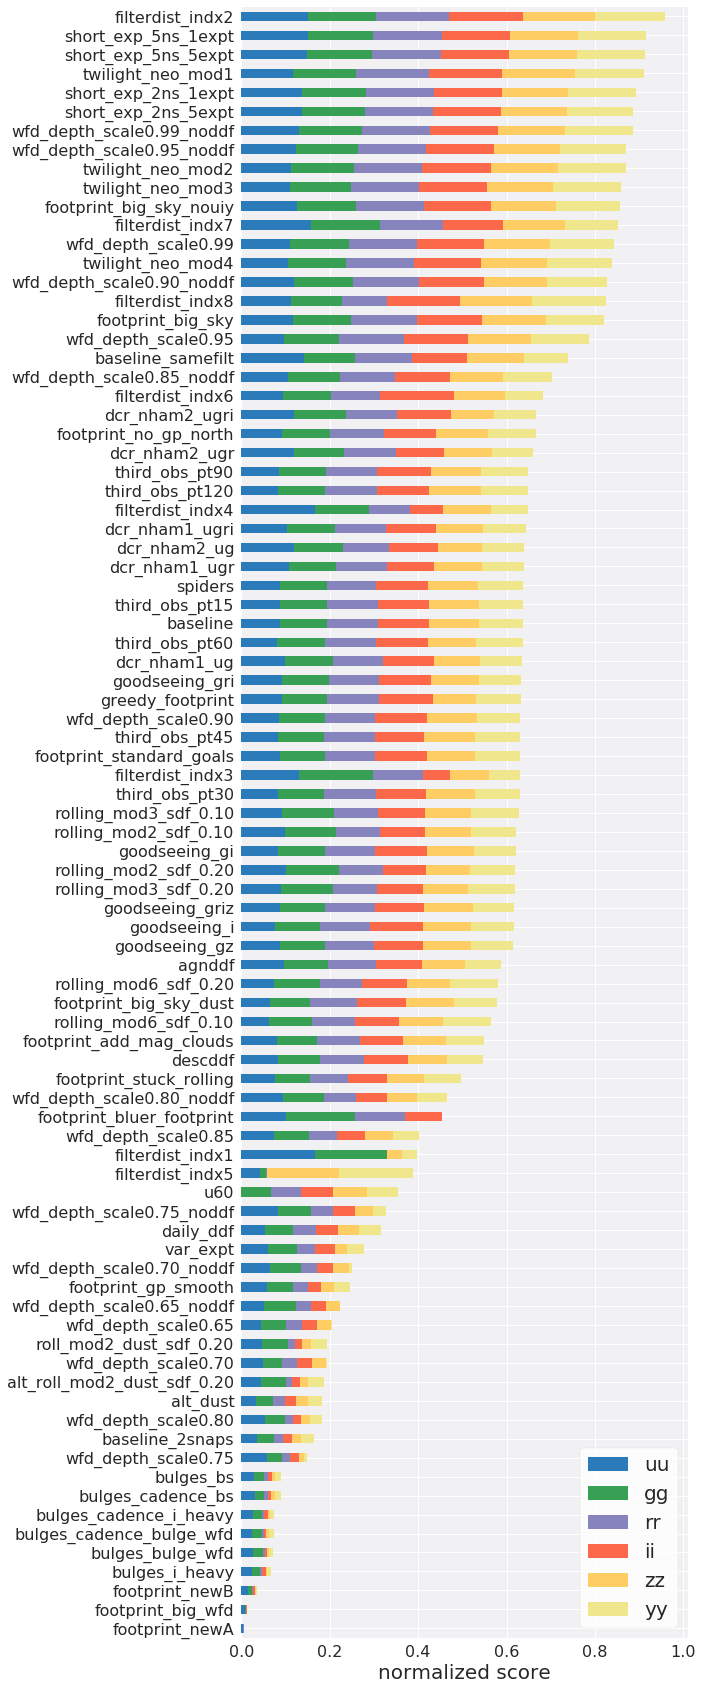

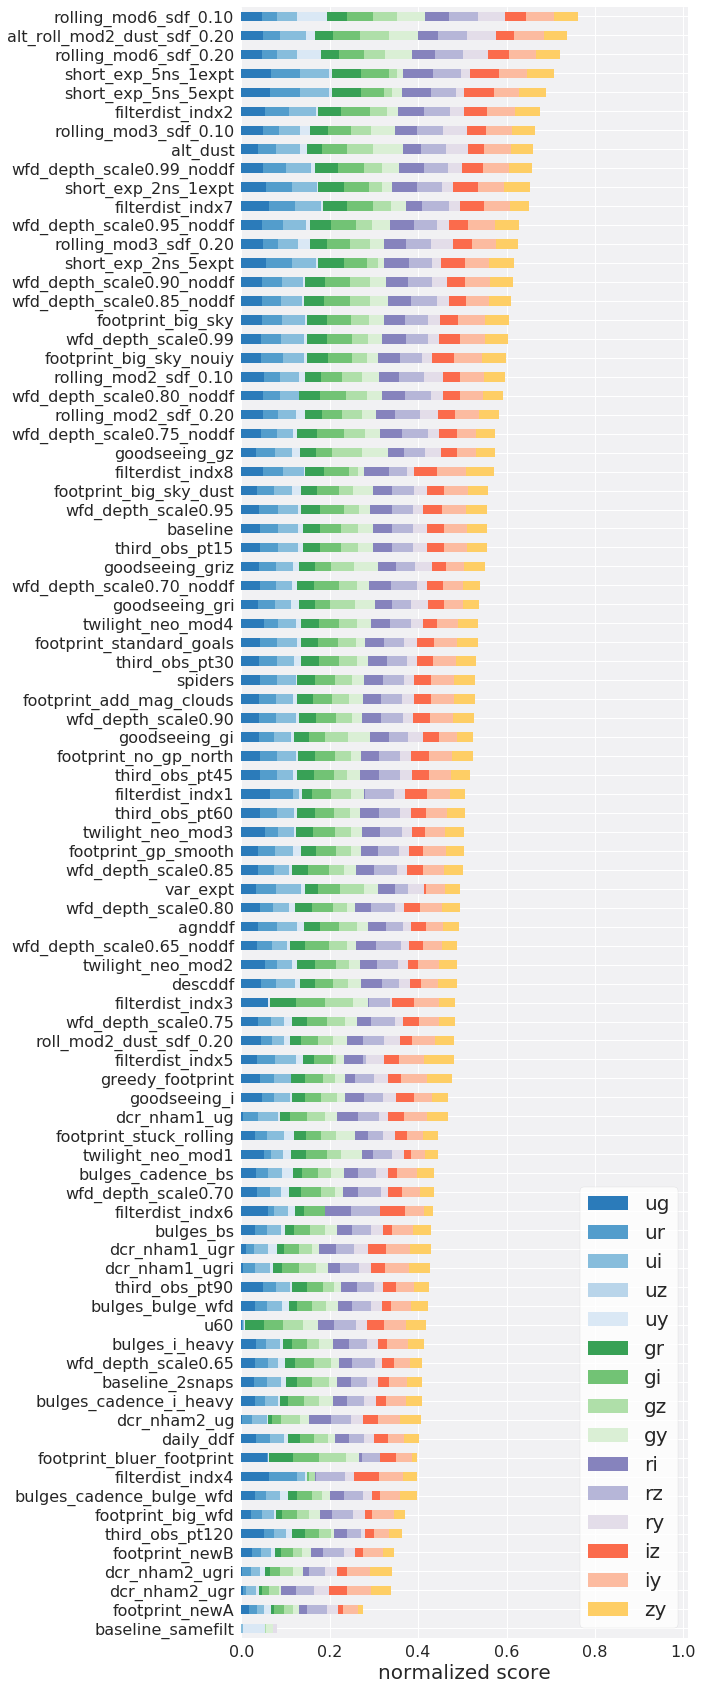

In [140]:
plot_barh(df_new, colon=cols_same, byfamily=False, savefig='figures/barh_EG_same.pdf', colormap=get_mycmap(pairs='same')) 

plot_barh(df_new, colon=cols_diff, byfamily=False, savefig='figures/barh_EG_diff.pdf', colormap=get_mycmap(pairs='diff')) 



### star density

In [141]:
fomcsv = './data/df_Nstars_allsky_v1.5.csv'
df_fom = pd.read_csv(fomcsv)

if 'db' not in df_fom.columns:
    df_fom['db'] = dblist_all


In [142]:
# scale fom table to 0 and 1
df_new = df_fom[ ['db'] ].copy()
for col in cols_all:
    # df_new[ col ] = np.tanh ( scale ( df_fom[col] ) * 3 )
    df_new[col] = scale(df_fom[col], mode=1) 
    
df_new['db'] = df_new['db'].apply(lambda x: x.replace("_v1.5_10yrs.db", "") )
df_new['db'] = df_new['db'].apply(lambda x: x.replace("v1.5_10yrs.db", "") )

df_new['family'] = df_new.apply(get_family, axis=1)

df_new.head()

,db,uu,ug,ur,ui,uz,uy,gg,gr,gi,...,ri,rz,ry,ii,iz,iy,zz,zy,yy,family
0,agnddf,0.234760,0.356928,0.217933,0.258835,NaN,0.012981,0.238160,0.229241,0.247957,...,0.247730,0.137032,0.143687,0.228024,0.228102,0.221047,0.213235,0.210922,0.192366,agnddf
1,alt_dust,0.047513,0.139931,0.124364,0.196760,NaN,0.169600,0.070965,0.122311,0.149315,...,0.136649,0.063788,0.259085,0.034647,0.113649,0.170086,0.038651,0.138028,0.051211,alt
2,alt_roll_mod2_dust_sdf_0.20,0.045723,0.232283,0.110814,0.209688,NaN,0.160518,0.073203,0.133092,0.157469,...,0.150694,0.185138,0.628772,0.023962,0.128441,0.165207,0.023444,0.145821,0.047710,alt
3,baseline_2snaps,0.112844,0.241233,0.175957,0.221379,NaN,0.106275,0.111081,0.172721,0.193642,...,0.211379,0.136388,0.318670,0.064407,0.179510,0.206017,0.068259,0.193242,0.084718,baseline
4,baseline_samefilt,0.327663,0.000000,0.000180,0.072581,NaN,0.169035,0.261079,0.000000,0.000000,...,0.000000,0.009602,0.081776,0.250107,0.000000,0.000000,0.259357,0.000000,0.205294,baseline


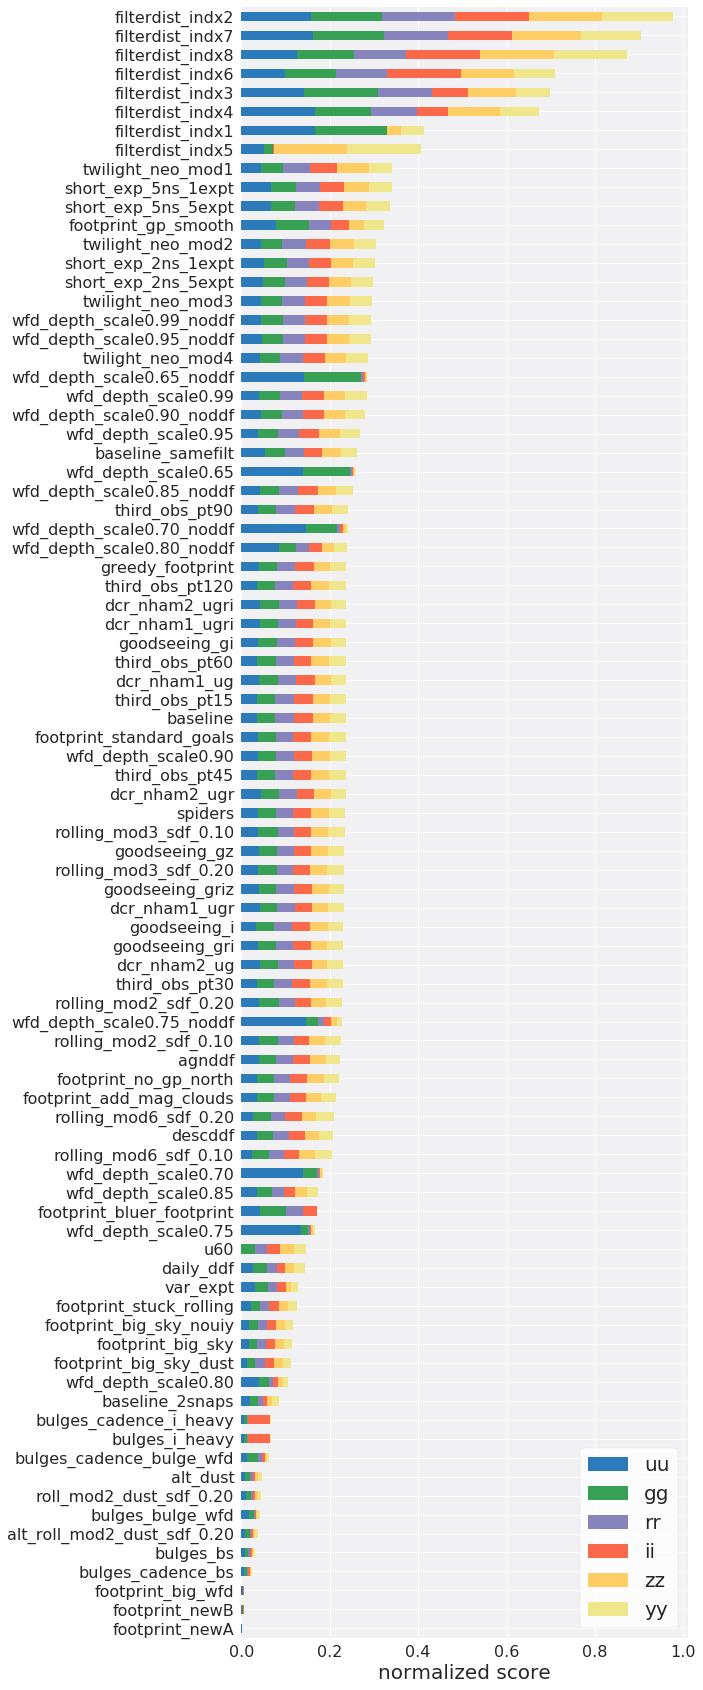

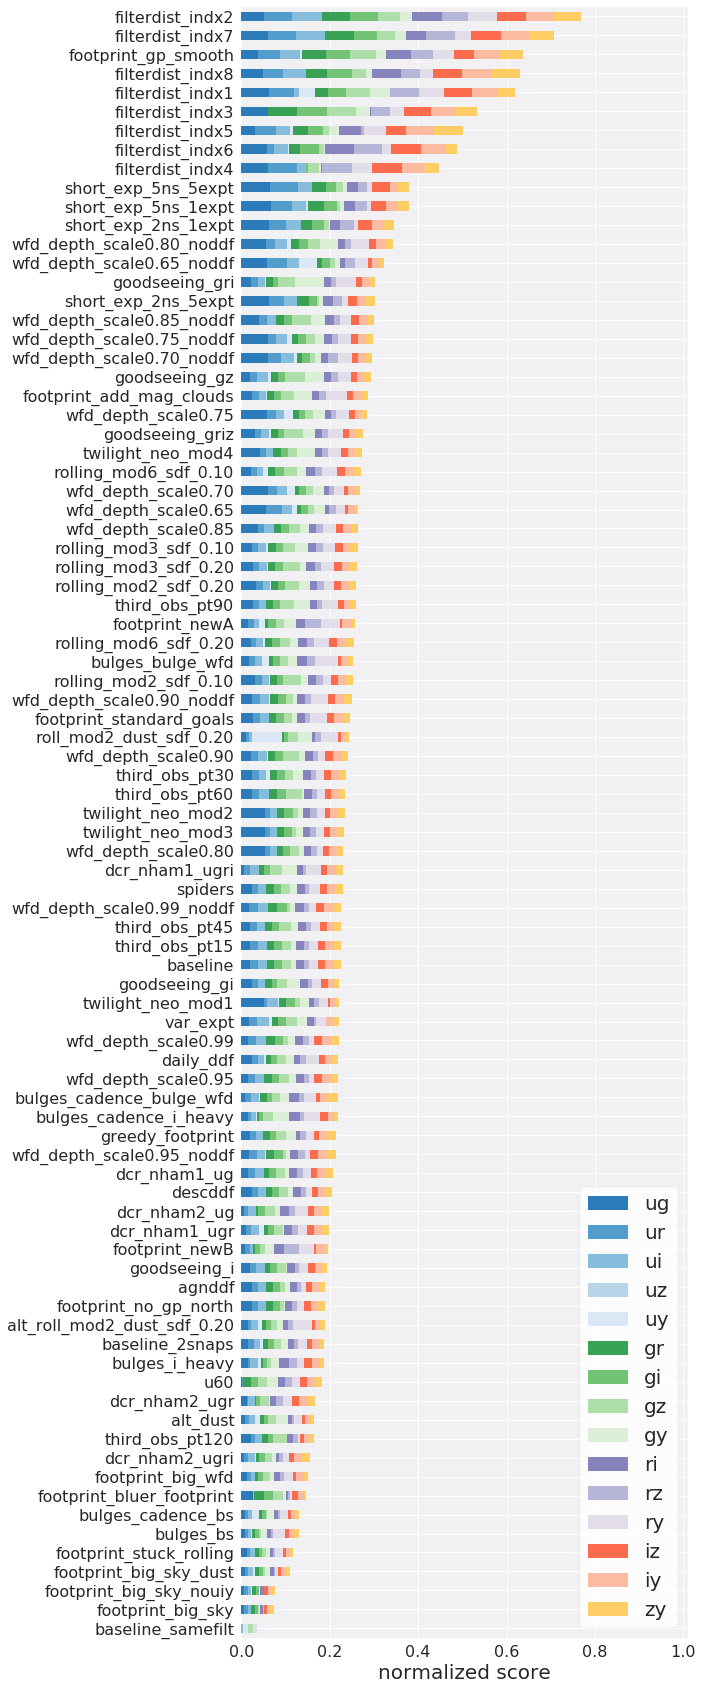

In [143]:
plot_barh(df_new, colon=cols_same, byfamily=False, savefig='figures/barh_Gal_same.pdf', colormap=get_mycmap(pairs='same')) 

plot_barh(df_new, colon=cols_diff, byfamily=False, savefig='figures/barh_Gal_diff.pdf', colormap=get_mycmap(pairs='diff')) 



### proper motion

### all

In [216]:
fomcsv = './data/df_radar.csv' 
df_fom = pd.read_csv(fomcsv)
df_fom.head()

,db,FoM_CI,FoM_LS,FoM_PMT,total,FoM_tgaps,FoM_EG,FoM_Gal,FoM_depth
0,agnddf_v1.5_10yrs,0.555133,NaN,0.583599,0.692068,0.443376,0.564762,0.610002,0.931742
1,alt_dust_v1.5_10yrs,0.768061,NaN,0.523405,0.784893,0.603965,0.554701,0.307607,0.800220
2,alt_roll_mod2_dust_sdf_0.20_v1.5_10yrs,0.768061,NaN,0.448807,0.739556,0.679559,0.644424,0.371077,0.692088
3,baseline_2snaps_v1.5_10yrs,0.577947,NaN,0.845955,0.865381,0.409759,0.330473,0.396784,0.863893
4,baseline_v1.5_10yrs,0.566540,NaN,0.663306,0.747443,0.477122,0.636859,0.673557,0.922776


In [217]:
FoMvars = ['FoM_tgaps', 'FoM_depth', 'FoM_EG', 'FoM_Gal', 'FoM_PMT']


In [218]:
# scale fom table to 0 and 1
df_new = df_fom[ ['db'] ].copy()
for col in FoMvars:
    # df_new[ col ] = np.tanh ( scale ( df_fom[col] ) * 3 )
    #df_new[col] = scale(df_fom[col], mode=1) 
    df_new[col] = df_fom[col]
    
df_new['db'] = df_new['db'].apply(lambda x: x.replace("_v1.5_10yrs", "") )
df_new['db'] = df_new['db'].apply(lambda x: x.replace("v1.5_10yrs", "") )

df_new['family'] = df_new.apply(get_family, axis=1)

df_new.head()

,db,FoM_tgaps,FoM_depth,FoM_EG,FoM_Gal,FoM_PMT,family
0,agnddf,0.443376,0.931742,0.564762,0.610002,0.583599,agnddf
1,alt_dust,0.603965,0.800220,0.554701,0.307607,0.523405,alt
2,alt_roll_mod2_dust_sdf_0.20,0.679559,0.692088,0.644424,0.371077,0.448807,alt
3,baseline_2snaps,0.409759,0.863893,0.330473,0.396784,0.845955,baseline
4,baseline,0.477122,0.922776,0.636859,0.673557,0.663306,baseline


In [219]:
FoMvars

['FoM_tgaps', 'FoM_depth', 'FoM_EG', 'FoM_Gal', 'FoM_PMT']

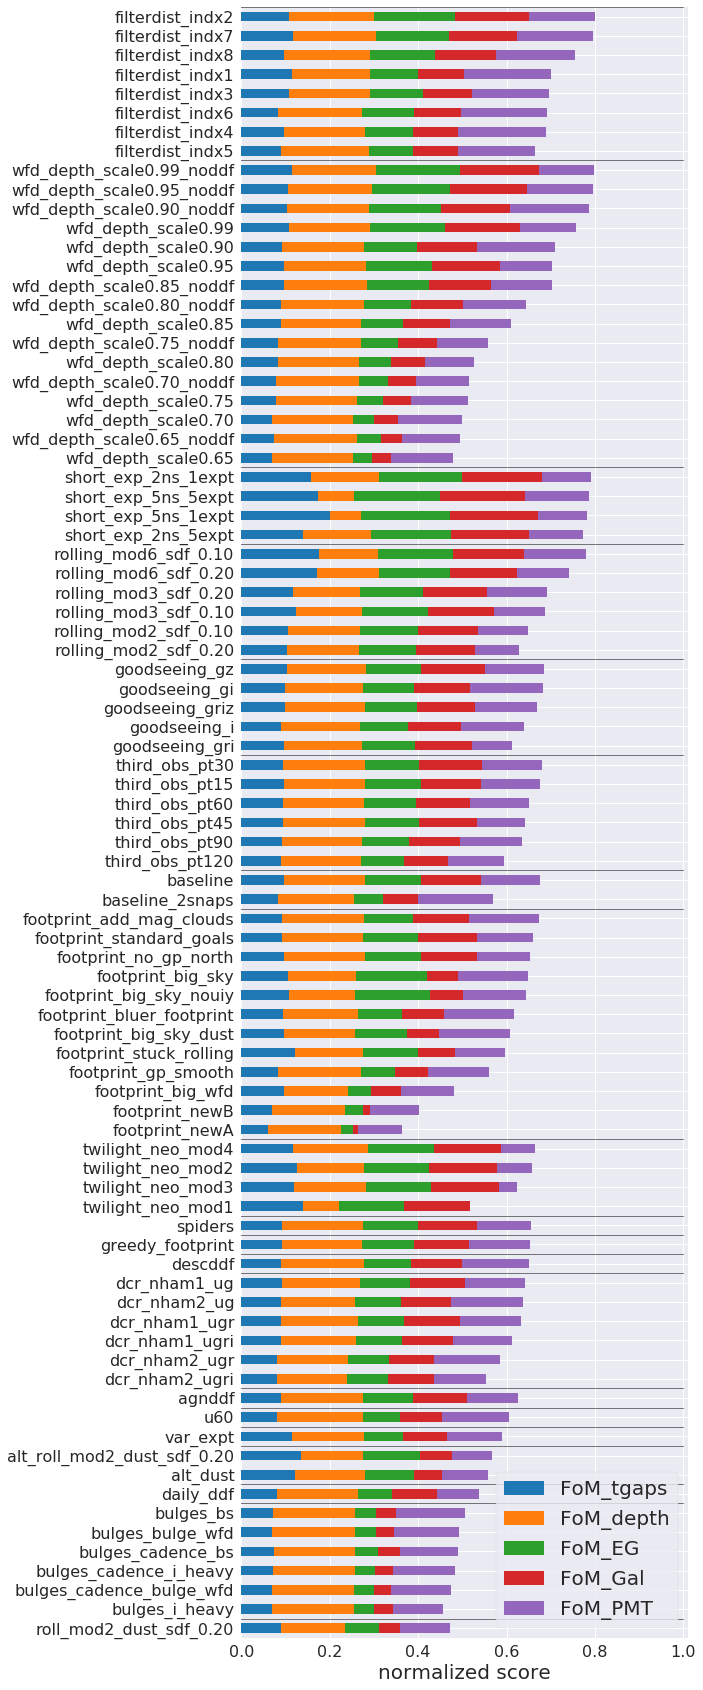

In [230]:
import matplotlib.colors as mcolors
colors = plt.cm.tab10( np.linspace(0., 1, 10) )[:5]
mymap = mcolors.LinearSegmentedColormap.from_list('my_colormap', colors)
    

plot_barh(df_new, colon=FoMvars, byfamily=True, savefig='figures/barh_all.pdf', colormap=mymap ) 

